# ANALYSIS ON THE VEHICLE 10020_95210

In [1]:
vehicle_code = "10020_95210"
stop = "5"

### IMPORT LIBRARIES

In [2]:
# psycopg2 is a library to execute sql queries in python
import psycopg2
# folium allows to visualize geolocalized data with the jupyter notebook
import folium
from folium.plugins import MarkerCluster
# sys is required to use the open function to write on file
import sys
# pandas is needed to read the csv file and to perform some basic operations on dataframes
import pandas as pd
# matplotlib is used to draw graphs
import matplotlib.pyplot as plt
# numpy is for scinetific computations
import numpy as np
# ST_AsGeoJSON returns a json object, so we can use json.load to parse it
import json
# scatter plot with color density
from scipy.stats import gaussian_kde

**WARNING! RUN ONLY ONCE TO SAVE THE CSV FILES!**

**YOU DON'T NEED TO CONNECT TO THE SERVER ONCE YOU ALREADY HAVE THE FILES**

### CONNECT TO THE DATASET

In [3]:
conn = psycopg2.connect("dbname=irpet", host="146.48.83.137", user="sbolgi", password="sbolgi2019", port="5435")

# the cursor allows Python code to execute PostgreSQL command in a database session.
cur = conn.cursor()

In [4]:
# First query: select all trajectories of vehicle 14710_129450
query1 = "SELECT * FROM tak.vodafone_zel1_traj_"+stop+"min WHERE vehicle = '"+ vehicle_code+"'"

# Store result in csv file to perform then other experiments
outputquery = "COPY ({0}) TO STDOUT WITH CSV HEADER".format(query1)

with open('../../../datasets/in/Traj'+stop+'min/vehicle_'+vehicle_code+'.csv', 'w', encoding='utf-8') as f:
    cur.copy_expert(outputquery, f)

In [5]:
# Store result in csv file but this time geometry is converted to coordinates

# First query: select all trajectories of vehicle 14710_129450
query1 = """
    SELECT vehicle, tid, ST_AsGeoJSON(traj) as trajcoord, company, vehicletype, length, duration, start_time, end_time
    FROM tak.vodafone_zel1_traj_"""+stop+"min WHERE vehicle = '"+ vehicle_code+"'"

# Store result in csv file to perform then other experiments
outputquery = "COPY ({0}) TO STDOUT WITH CSV HEADER".format(query1)

with open('../../../datasets/out/Traj'+stop+'min/vehicle_'+vehicle_code+'_coord.csv', 'w', encoding='utf-8') as f:
    cur.copy_expert(outputquery, f)

In [6]:
conn.close()

###### Open csv just created and execute usual statistics

In [7]:
df = pd.read_csv('../../../datasets/in/Traj'+stop+'min/vehicle_'+vehicle_code+'.csv') 

In [8]:
print("The dataset has", df.shape[0], "rows and", df.shape[1], "columns.")

The dataset has 6513 rows and 9 columns.


In [9]:
df.head(5)

,vehicle,tid,traj,company,vehicletype,length,duration,start_time,end_time
0,10020_95210,3692,01020000A0E610000002000000438D429259F1364062DB...,30060,Truck 3,0.000000,7.28,2017-10-13 14:55:21,2017-10-13 14:55:28
1,10020_95210,12799,01020000A0E610000002000000B3EBDE8AC4F83640AD6C...,30060,Truck 3,0.017865,36.26,2018-06-23 04:07:08,2018-06-23 04:07:44
2,10020_95210,1467,01020000A0E6100000030000009015FC36C4F8364048A7...,30060,Truck 3,0.027861,52.79,2017-08-11 09:03:22,2017-08-11 09:04:15
3,10020_95210,12743,01020000A0E61000000300000033DDEBA4BEF83640463F...,30060,Truck 3,0.008937,8.87,2018-06-22 07:35:59,2018-06-22 07:36:07
4,10020_95210,12744,01020000A0E6100000020000007C0E2C47C8F83640490F...,30060,Truck 3,0.004383,10.21,2018-06-22 07:49:38,2018-06-22 07:49:48


In [10]:
print("the vehicle is characterized by 8 fields")
print("tid: has ", len(df["tid"].unique()), "unique values")
print("company: has ", len(df["company"].unique()), "unique values: ", df["company"].unique())
print("vehicletype: has ", len(df["vehicletype"].unique()), "unique values")

the vehicle is characterized by 8 fields
tid: has  6513 unique values
company: has  2 unique values:  ['30060' '\ufeff30060']
vehicletype: has  1 unique values


In [11]:
df[["length", "duration"]].describe()

,length,duration
count,6513.000000,6513.000000
mean,1.733984,537.758087
std,4.070649,528.034317
min,0.000000,0.060000
25%,0.178467,179.260000
50%,0.563586,367.260000
75%,1.400332,725.890000
max,103.824427,5478.130000


the 90% of the total is  5861.7
the length of the 90% is  3.820415698481781
the duration of the 90% is  1224.47


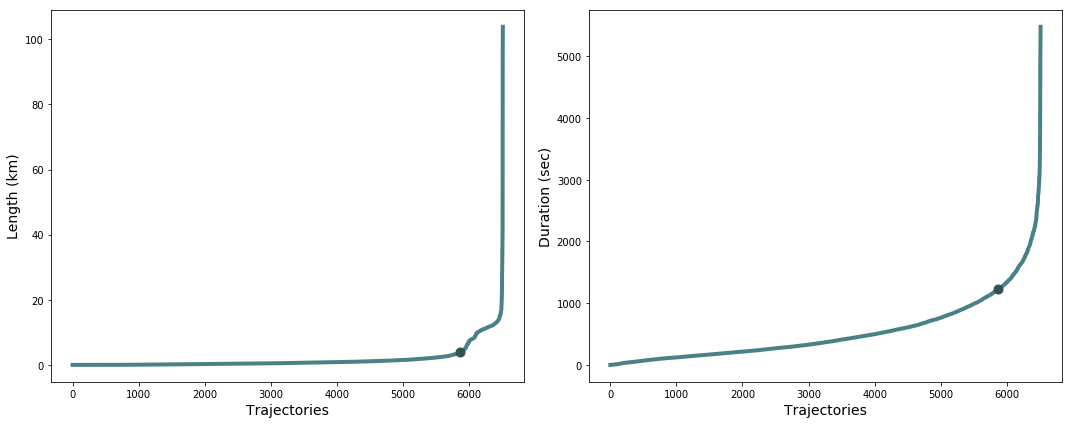

In [12]:
perc90 = (df.shape[0] * 90)/100
print("the 90% of the total is ", perc90)

perc90_i = int(perc90)

print("the length of the 90% is ", sorted(df["length"])[perc90_i])
print("the duration of the 90% is ", sorted(df["duration"])[perc90_i])

fig = plt.figure(figsize=(15, 6)) 
fig_dims = (1, 2)

ax = plt.subplot2grid(fig_dims, (0, 0))
ax.plot(range(0,df.shape[0]), sorted(df["length"]), color='#488286', linewidth=4)
plt.plot(perc90_i, sorted(df["length"])[perc90_i], 'o', color='#305252', markersize=9)
plt.xlabel("Trajectories", fontsize=14)
plt.ylabel("Length (km)", fontsize=14)

ax = plt.subplot2grid(fig_dims, (0, 1))
ax.plot(range(0,df.shape[0]), sorted(df["duration"]), color='#488286', linewidth=4)
plt.plot(perc90_i, sorted(df["duration"])[perc90_i], 'o', color='#305252', markersize=9)
plt.xlabel("Trajectories", fontsize=14)
plt.ylabel("Duration (sec)", fontsize=14)

plt.tight_layout()

plt.savefig('../../../thesis/images/Traj'+stop+'_'+vehicle_code+'_distr.png', format='png', bbox_inches='tight')

### let's zoom on the values "in the area", hence for less than 0.2 km

In [13]:
df_mini = df[df["length"] < 0.2]

The number of trajectories that lasted for less than 200 meters is 1747


C:\Users\Francesca\Anaconda3\lib\site-packages\pandas\core\series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


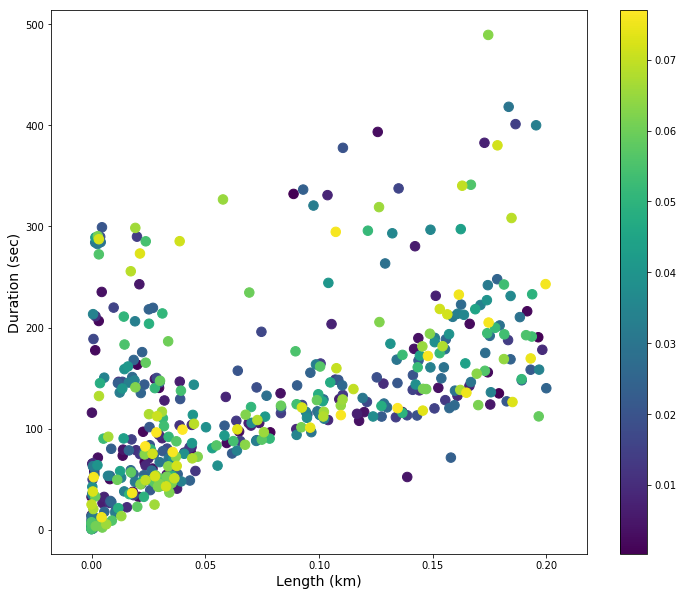

In [14]:
print("The number of trajectories that lasted for less than 200 meters is", df_mini.shape[0])

fig = plt.figure(figsize=(12, 10)) 
fig_dims = (1, 1)

x = df_mini["length"]
y = df_mini["duration"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

ax = plt.subplot2grid(fig_dims, (0, 0))
density = ax.scatter(x, y, c=z, s=90)
fig.colorbar(density)

plt.xlabel("Length (km)", fontsize=14)
plt.ylabel("Duration (sec)", fontsize=14)

plt.savefig('../../../thesis/images/Traj'+stop+'_'+vehicle_code+'_200m.png', format='png', bbox_inches='tight')

## This time we use the csv with the coordinates to try to plot them

In [15]:
df_coord = pd.read_csv('../../../datasets/out/Traj'+stop+'min/vehicle_'+vehicle_code+'_coord.csv') 

In [16]:
def swapXY(traj):
    new_traj = []
    for i in traj:
        new_traj.append([i[1], i[0]])
    return new_traj

In [17]:
coords = []

for el in  df_coord["trajcoord"]:
    y = json.loads(el)
    c = swapXY(y["coordinates"])
    coords.append(c)

In [18]:
df_coord["coord"] = coords
df_coord = df_coord.drop(columns=['vehicle','trajcoord']) 

df_coord.head(5)

,tid,company,vehicletype,length,duration,start_time,end_time,coord
0,3692,30060,Truck 3,0.000000,7.28,2017-10-13 14:55:21,2017-10-13 14:55:28,"[[40.63302, 22.942773], [40.63302, 22.942773]]"
1,12799,30060,Truck 3,0.017865,36.26,2018-06-23 04:07:08,2018-06-23 04:07:44,"[[40.574919, 22.971749], [40.574879, 22.971954]]"
2,1467,30060,Truck 3,0.027861,52.79,2017-08-11 09:03:22,2017-08-11 09:04:15,"[[40.574905, 22.971744], [40.57506, 22.971767]..."
3,12743,30060,Truck 3,0.008937,8.87,2018-06-22 07:35:59,2018-06-22 07:36:07,"[[40.574991, 22.971659], [40.575033, 22.971633..."
4,12744,30060,Truck 3,0.004383,10.21,2018-06-22 07:49:38,2018-06-22 07:49:48,"[[40.574819, 22.971806], [40.574782, 22.971824]]"


The majority of trajectories are not relevant. We can consider all trajectories beaneath a certain threashold just as GPS errors. In particular we consider just trajectories where the _length_ is at least 0.2 km;

In [19]:
#remove trajectories of less than 200 meters
df_long = df_coord[df_coord["length"] > 0.2].copy(deep=True)

In [20]:
print ("Of the total", df_coord.shape[0], "just", df_long.shape[0], "are trajectories are significant")

Of the total 6513 just 4766 are trajectories are significant


In [21]:
df_long.head(5)

,tid,company,vehicletype,length,duration,start_time,end_time,coord
11,10403,30060,Truck 3,0.269758,216.60,2018-04-19 10:52:00,2018-04-19 10:55:37,"[[40.630977, 22.94567], [40.631008, 22.945649]..."
13,10405,30060,Truck 3,0.586440,425.11,2018-04-19 11:23:56,2018-04-19 11:31:02,"[[40.632968, 22.942753], [40.63303, 22.942611]..."
14,12699,30060,Truck 3,0.571905,177.96,2018-06-21 13:37:07,2018-06-21 13:40:05,"[[40.634812, 22.946304], [40.634852, 22.946116..."
20,64,30060,Truck 3,0.280724,448.31,2017-07-03 11:15:00,2017-07-03 11:22:28,"[[40.630683, 22.946424], [40.63079, 22.946316]..."
21,57,30060,Truck 3,11.103351,950.65,2017-07-03 09:46:27,2017-07-03 10:02:17,"[[40.574924, 22.97168], [40.575045, 22.971824]..."


**The problem is that we can't draw all the trajectories together, it's a computation too heavy**

We can split it for periods of time

In [22]:
print("the first trajectory starts at", min(df_long["start_time"]))
print("the last trajectory finish at", max(df_long["start_time"]))

the first trajectory starts at 2017-07-03 09:46:27
the last trajectory finish at 2018-06-29 15:51:03


In [23]:
df_long.loc[:, 'start_month'] = pd.DatetimeIndex(df_long['start_time']).month

In [24]:
def center_traj(coords):
    sum_x = 0
    sum_y = 0
    for i in coords:
        sum_x += i[0][0]
        sum_y += i[0][1]
    c_x = sum_x / len(coords)
    c_y = sum_y / len(coords)
    return c_x, c_y

**JULY 2017**

In [33]:
df_july = df_long[df_long["start_month"] == 7]

In [34]:
print ("in july this vehicle has", len(df_july), "significant trajectories")

in july this vehicle has 400 significant trajectories


In [35]:
coords = df_july["coord"].tolist()
c_x, c_y = center_traj(coords)

In [37]:
colors = ['gray', 'orange', 'green', 'lightred', 'darkgreen', 'darkblue', 'darkred', 'pink', 
          'lightgrayblack', 'lightblue', 'cadetblue', 'darkpurple', 'lightgreen', 'purple', 'blue', 'red', 'beige']

m = folium.Map(location=[c_x, c_y], zoom_start=8)
for i in range(len(df_july)):
    my_PolyLine=folium.PolyLine(locations=coords[i], weight=5, color=colors[i%17])
    m.add_child(my_PolyLine)
    
mc = MarkerCluster()
for i in range(len(df_july)):
    marker = folium.Marker(location=coords[i][0], popup=i, icon=folium.Icon(color=colors[i%17],icon='play'))
    mc.add_child(marker)
    
    marker = folium.Marker(location=coords[i][-1], popup=i, icon=folium.Icon(color=colors[i%17],icon='stop'))
    mc.add_child(marker)

m.add_child(mc)
m

**JANUARY 2018**

In [29]:
df_jan = df_long[df_long["start_month"] == 1]

In [30]:
print ("in january this vehicle has", len(df_jan), "significant trajectories")

in january this vehicle has 405 significant trajectories


In [31]:
coords = df_jan["coord"].tolist()
c_x, c_y = center_traj(coords)

In [32]:
colors = ['gray', 'orange', 'green', 'lightred', 'darkgreen', 'darkblue', 'darkred', 'pink', 
          'lightgrayblack', 'lightblue', 'cadetblue', 'darkpurple', 'lightgreen', 'purple', 'blue', 'red', 'beige']

m = folium.Map(location=[c_x, c_y], zoom_start=8.4)
for i in range(len(df_jan)):
    my_PolyLine=folium.PolyLine(locations=coords[i], weight=5, color=colors[i%17])
    m.add_child(my_PolyLine)
    
mc = MarkerCluster()
for i in range(len(df_jan)):
    marker = folium.Marker(location=coords[i][0], popup=i, icon=folium.Icon(color=colors[i%17],icon='play'))
    mc.add_child(marker)
    
    marker = folium.Marker(location=coords[i][-1], popup=i, icon=folium.Icon(color=colors[i%17],icon='stop'))
    mc.add_child(marker)

m.add_child(mc)
m